### Import libraries and read data

In [1254]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
% matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.utils import resample
from sklearn.cluster import KMeans
from scipy.stats import zscore
from scipy.spatial.distance import cdist

In [1255]:
# read the dataset
house_value_df = pd.read_csv("innercity.csv")
house_value_df.head()

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
0,3034200666,20141107T000000,808100,4,3.25,3020,13457,1.0,0,0,...,0,1956,0,98133,47.7174,-122.336,2120,7553,1,16477
1,8731981640,20141204T000000,277500,4,2.50,2550,7500,1.0,0,0,...,800,1976,0,98023,47.3165,-122.386,2260,8800,0,10050
2,5104530220,20150420T000000,404000,3,2.50,2370,4324,2.0,0,0,...,0,2006,0,98038,47.3515,-121.999,2370,4348,0,6694
3,6145600285,20140529T000000,300000,2,1.00,820,3844,1.0,0,0,...,0,1916,0,98133,47.7049,-122.349,1520,3844,0,4664
4,8924100111,20150424T000000,699000,2,1.50,1400,4050,1.0,0,0,...,0,1954,0,98115,47.6768,-122.269,1900,5940,0,5450


In [1256]:
a = house_value_df[house_value_df.living_measure > house_value_df.lot_measure]
a.groupby('ceil').count()

,cid,dayhours,price,room_bed,room_bath,living_measure,lot_measure,coast,sight,condition,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
ceil,,,,,,,,,,,,,,,,,,,,,
1.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1.5,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
2.0,391,391,391,391,391,391,391,391,391,391,...,391,391,391,391,391,391,391,391,391,391
2.5,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
3.0,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
3.5,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


### Exploratory Data Analysis

In [1257]:
# Shape of the dataset
house_value_df.shape

(21613, 23)

In [1258]:
# Check for information on dataset like null values, datatypes
house_value_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 23 columns):
cid                 21613 non-null int64
dayhours            21613 non-null object
price               21613 non-null int64
room_bed            21613 non-null int64
room_bath           21613 non-null float64
living_measure      21613 non-null int64
lot_measure         21613 non-null int64
ceil                21613 non-null float64
coast               21613 non-null int64
sight               21613 non-null int64
condition           21613 non-null int64
quality             21613 non-null int64
ceil_measure        21613 non-null int64
basement            21613 non-null int64
yr_built            21613 non-null int64
yr_renovated        21613 non-null int64
zipcode             21613 non-null int64
lat                 21613 non-null float64
long                21613 non-null float64
living_measure15    21613 non-null int64
lot_measure15       21613 non-null int64
furnished           2

In [1259]:
# Check for duplication of cid since it is a unique identifier, the duplicate values must be explained
cid_df = house_value_df[house_value_df.cid.duplicated(False) == True]
cid_df.sort_values(by="cid")[["cid", "dayhours", "price", "yr_renovated"]]

,cid,dayhours,price,yr_renovated
3405,1000102,20150422T000000,300000,0
17038,1000102,20140916T000000,280000,0
3874,7200179,20150424T000000,175000,0
19995,7200179,20141016T000000,150000,0
1727,109200390,20141020T000000,250000,0
...,...,...,...,...
12028,9828200460,20150106T000000,430000,0
13980,9834200305,20140716T000000,350000,0
1624,9834200305,20150210T000000,615000,0
6323,9834200885,20150420T000000,550000,0


Findings:

1. Dataset has 23 columns and 21613 records with no null values.
2. Out of the 23 columns, 
    1. dayhours is only feature which is of object type but has date on which the house was sold.
    2. all the columns apart from dayhours are numerical, however room_bed, room_bath, coast, sight, condition, quality and furnished can be treated as categorical variables.
    3. cid is a unique identifier for a house and thus it can't be a good predictor for the price since it won't contribute to any pattern in identification. 
    4. There are 177 records with duplication of cid, these records are resultant of reselling the same house multiple times.

In [1260]:
# Making a copy of original dataset to keep it intact through the preprocessing
houses_df = house_value_df.copy()

In [1261]:
# Setting cid as index to avoid the use of cid as a predictor
# Setting dayhours as index as it is an object datatype and will raise an error if used in the model as it is

houses_df.set_index(["cid", "dayhours"], inplace=True)
houses_df.head()

,,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,...,basement,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area
cid,dayhours,,,,,,,,,,,,,,,,,,,,,
3034200666,20141107T000000,808100,4,3.25,3020,13457,1.0,0,0,5,9,...,0,1956,0,98133,47.7174,-122.336,2120,7553,1,16477
8731981640,20141204T000000,277500,4,2.50,2550,7500,1.0,0,0,3,8,...,800,1976,0,98023,47.3165,-122.386,2260,8800,0,10050
5104530220,20150420T000000,404000,3,2.50,2370,4324,2.0,0,0,3,8,...,0,2006,0,98038,47.3515,-121.999,2370,4348,0,6694
6145600285,20140529T000000,300000,2,1.00,820,3844,1.0,0,0,4,6,...,0,1916,0,98133,47.7049,-122.349,1520,3844,0,4664
8924100111,20150424T000000,699000,2,1.50,1400,4050,1.0,0,0,4,8,...,0,1954,0,98115,47.6768,-122.269,1900,5940,0,5450


In [1262]:
# Shape of the modified dataset - number of features reduced to 21 as cid and dayhours are set as index
houses_df.shape

(21613, 21)

In [1263]:
# Descriptive statistics to check 5 point summary and brief overview on the distribution of each columns
houses_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540182.158793,367362.231718,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
room_bed,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
room_bath,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
living_measure,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
lot_measure,21613.0,15106.967566,41420.511515,520.0000,5040.000,7618.0000,10688.000,1.651359e+06
ceil,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
coast,21613.0,0.007542,0.086517,0.0000,0.000,0.0000,0.000,1.000000e+00
sight,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
condition,21613.0,3.409430,0.650743,1.0000,3.000,3.0000,4.000,5.000000e+00
quality,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01


In [1264]:
def plot_distribution(data, columns_names, column_type="Numeric", plot_type=None, target_column=None):
    '''
    Plots different plots based on the given parameters
    
    plot_type: possible values are [boxplot, pairplot, None]
    target_column: used for pair plot, column against which other columns need to be plotted
    '''
    plt.figure(figsize= (40,30))
    pos=1
    for col in columns_names:
        if(plot_type == None):
            plt.subplot(6, 4, pos)
            if(column_type.lower() == 'numeric'):
                sns.distplot(data[col], kde=True, label=col.capitalize())
            elif(column_type.lower() == 'category'):
                sns.countplot(data[col])
            else:
                print("Numeric and Category are only valid column types")
        elif(plot_type.lower() == "box plot"):
            plt.subplot(6, 4, pos)
            sns.boxplot(col, data=data)
        elif(plot_type.lower() == "pair plot"):
            sns.pairplot(data, x_vars=[col], y_vars=[target_column])
        else:
            print("This plot type is not available")
        pos += 1

def get_outlier_data(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    outlier_data_low = data[(data < low)]
    outlier_data_high = data[(data > high)]
    return outlier_data_low, outlier_data_high, low, high

def get_additional_info(data, columns, col_type = "Numerical", percentile = 0.9):
    '''
    Provides additional information for the columns like outlier count and where the nth percentile of the data lies
    '''
    info_data = data[columns]
    info_df = pd.DataFrame(info_data.quantile(percentile))
    info_df.columns = ['90%']
    info_df["Percentage"] = info_data[info_data <= info_data.quantile(percentile)].count() / info_data.count(axis=0)
    outlier_data_low, outlier_data_high, lower_cap, upper_cap = get_outlier_data(info_data)
    info_df["outlier_count_low"] = outlier_data_low.count()
    info_df["outlier_count_high"] = outlier_data_high.count()
    return(info_df)

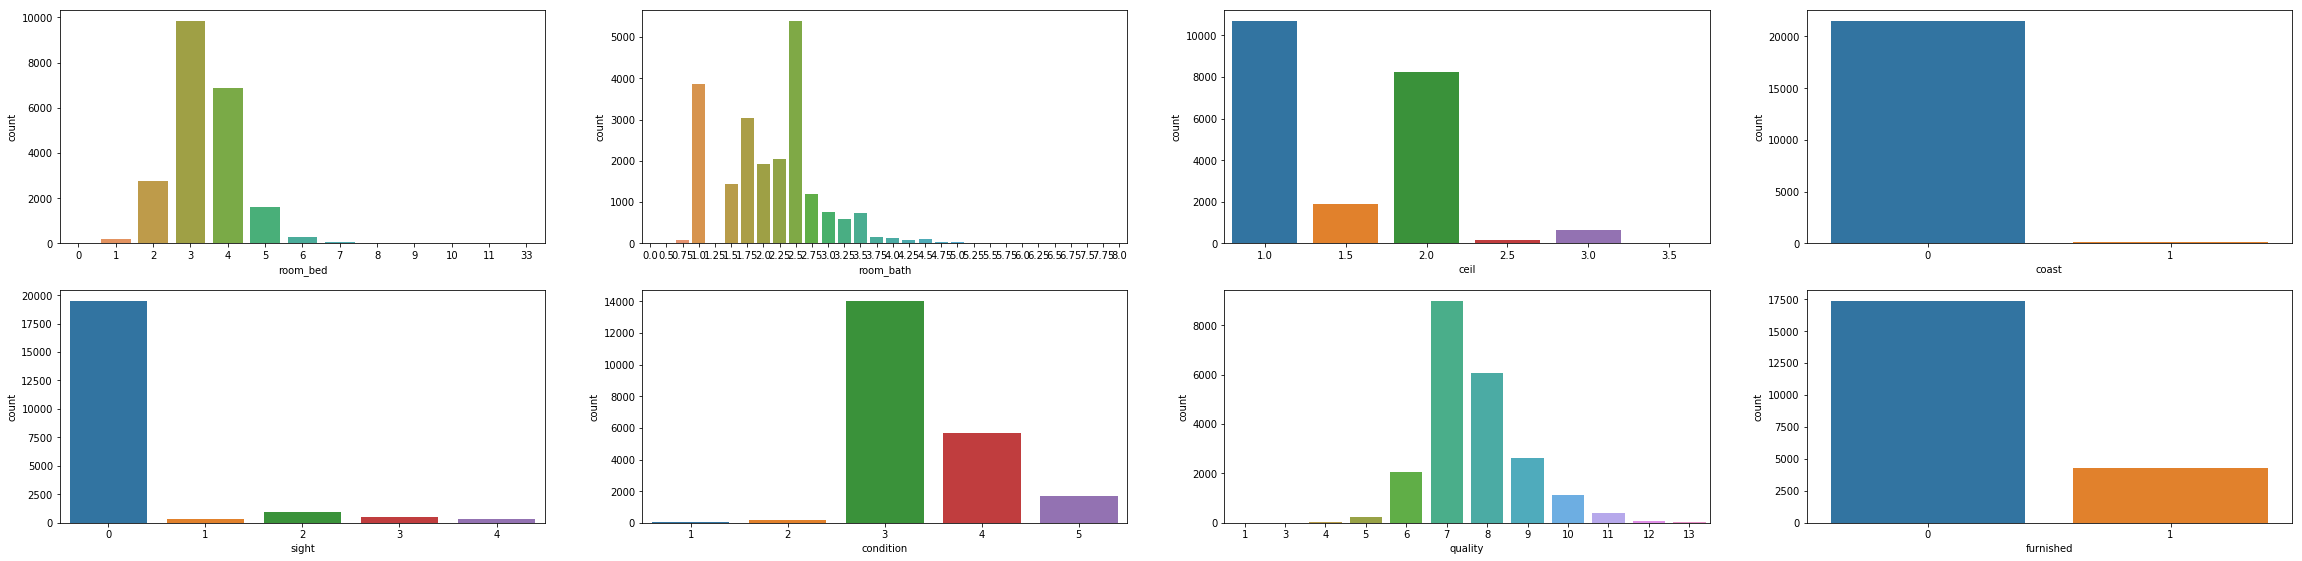

In [1265]:
# Plotting the categorical variables using countplot
category_cols = ["room_bed", "room_bath", "ceil", "coast", "sight", "condition", "quality", "furnished"]
plot_distribution(houses_df, category_cols, 'Category')

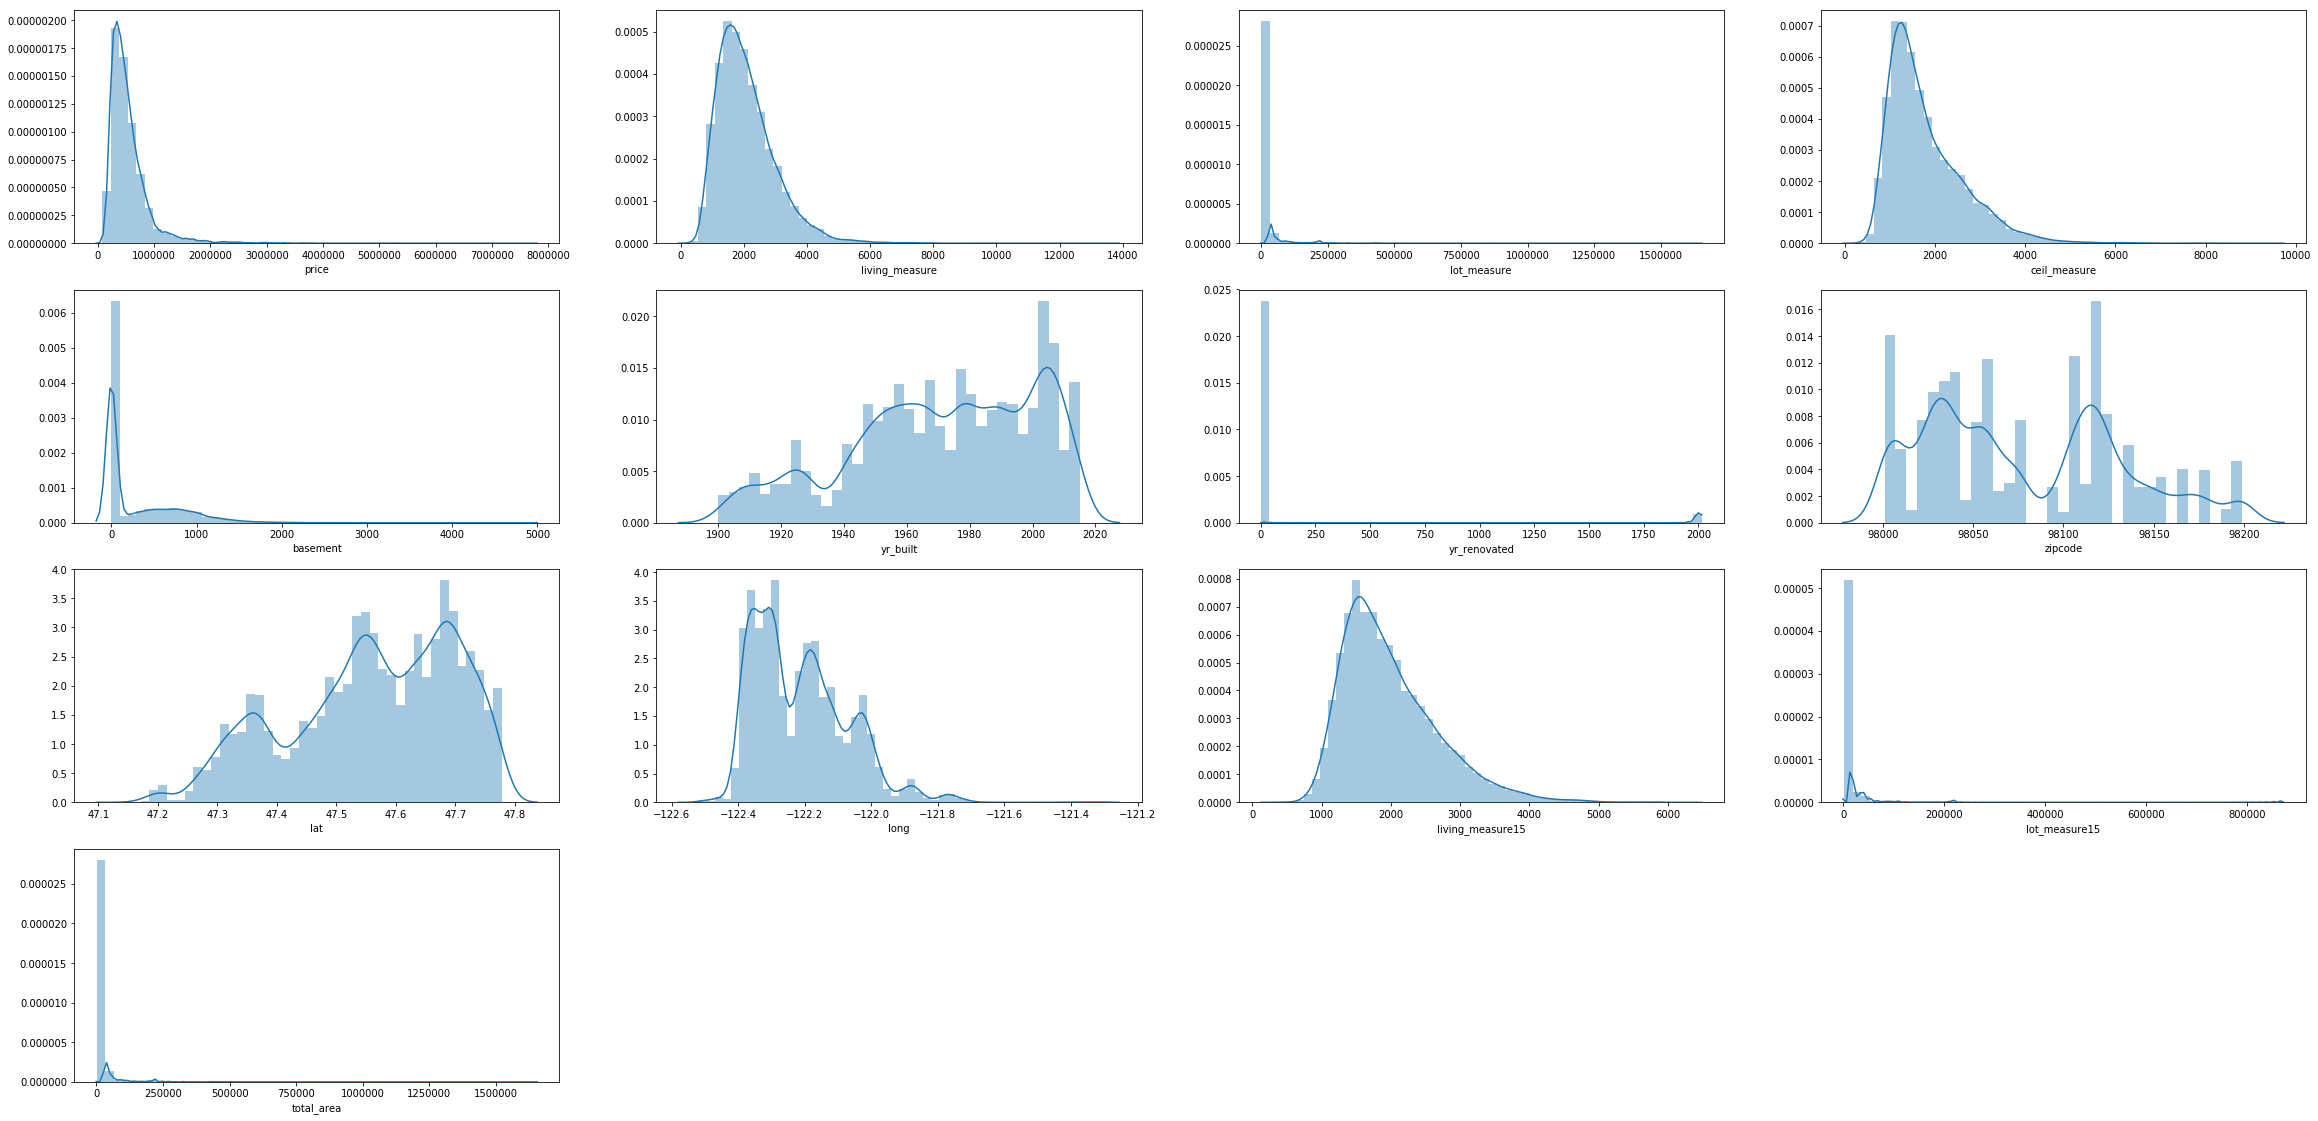

In [1266]:
#Plotting distplot for all columns excluding the columns which are categorical 
numeric_cols = [x for x in houses_df.dtypes[houses_df.dtypes != 'object'].index.tolist() if x not in category_cols]
plot_distribution(houses_df, numeric_cols, 'Numeric')

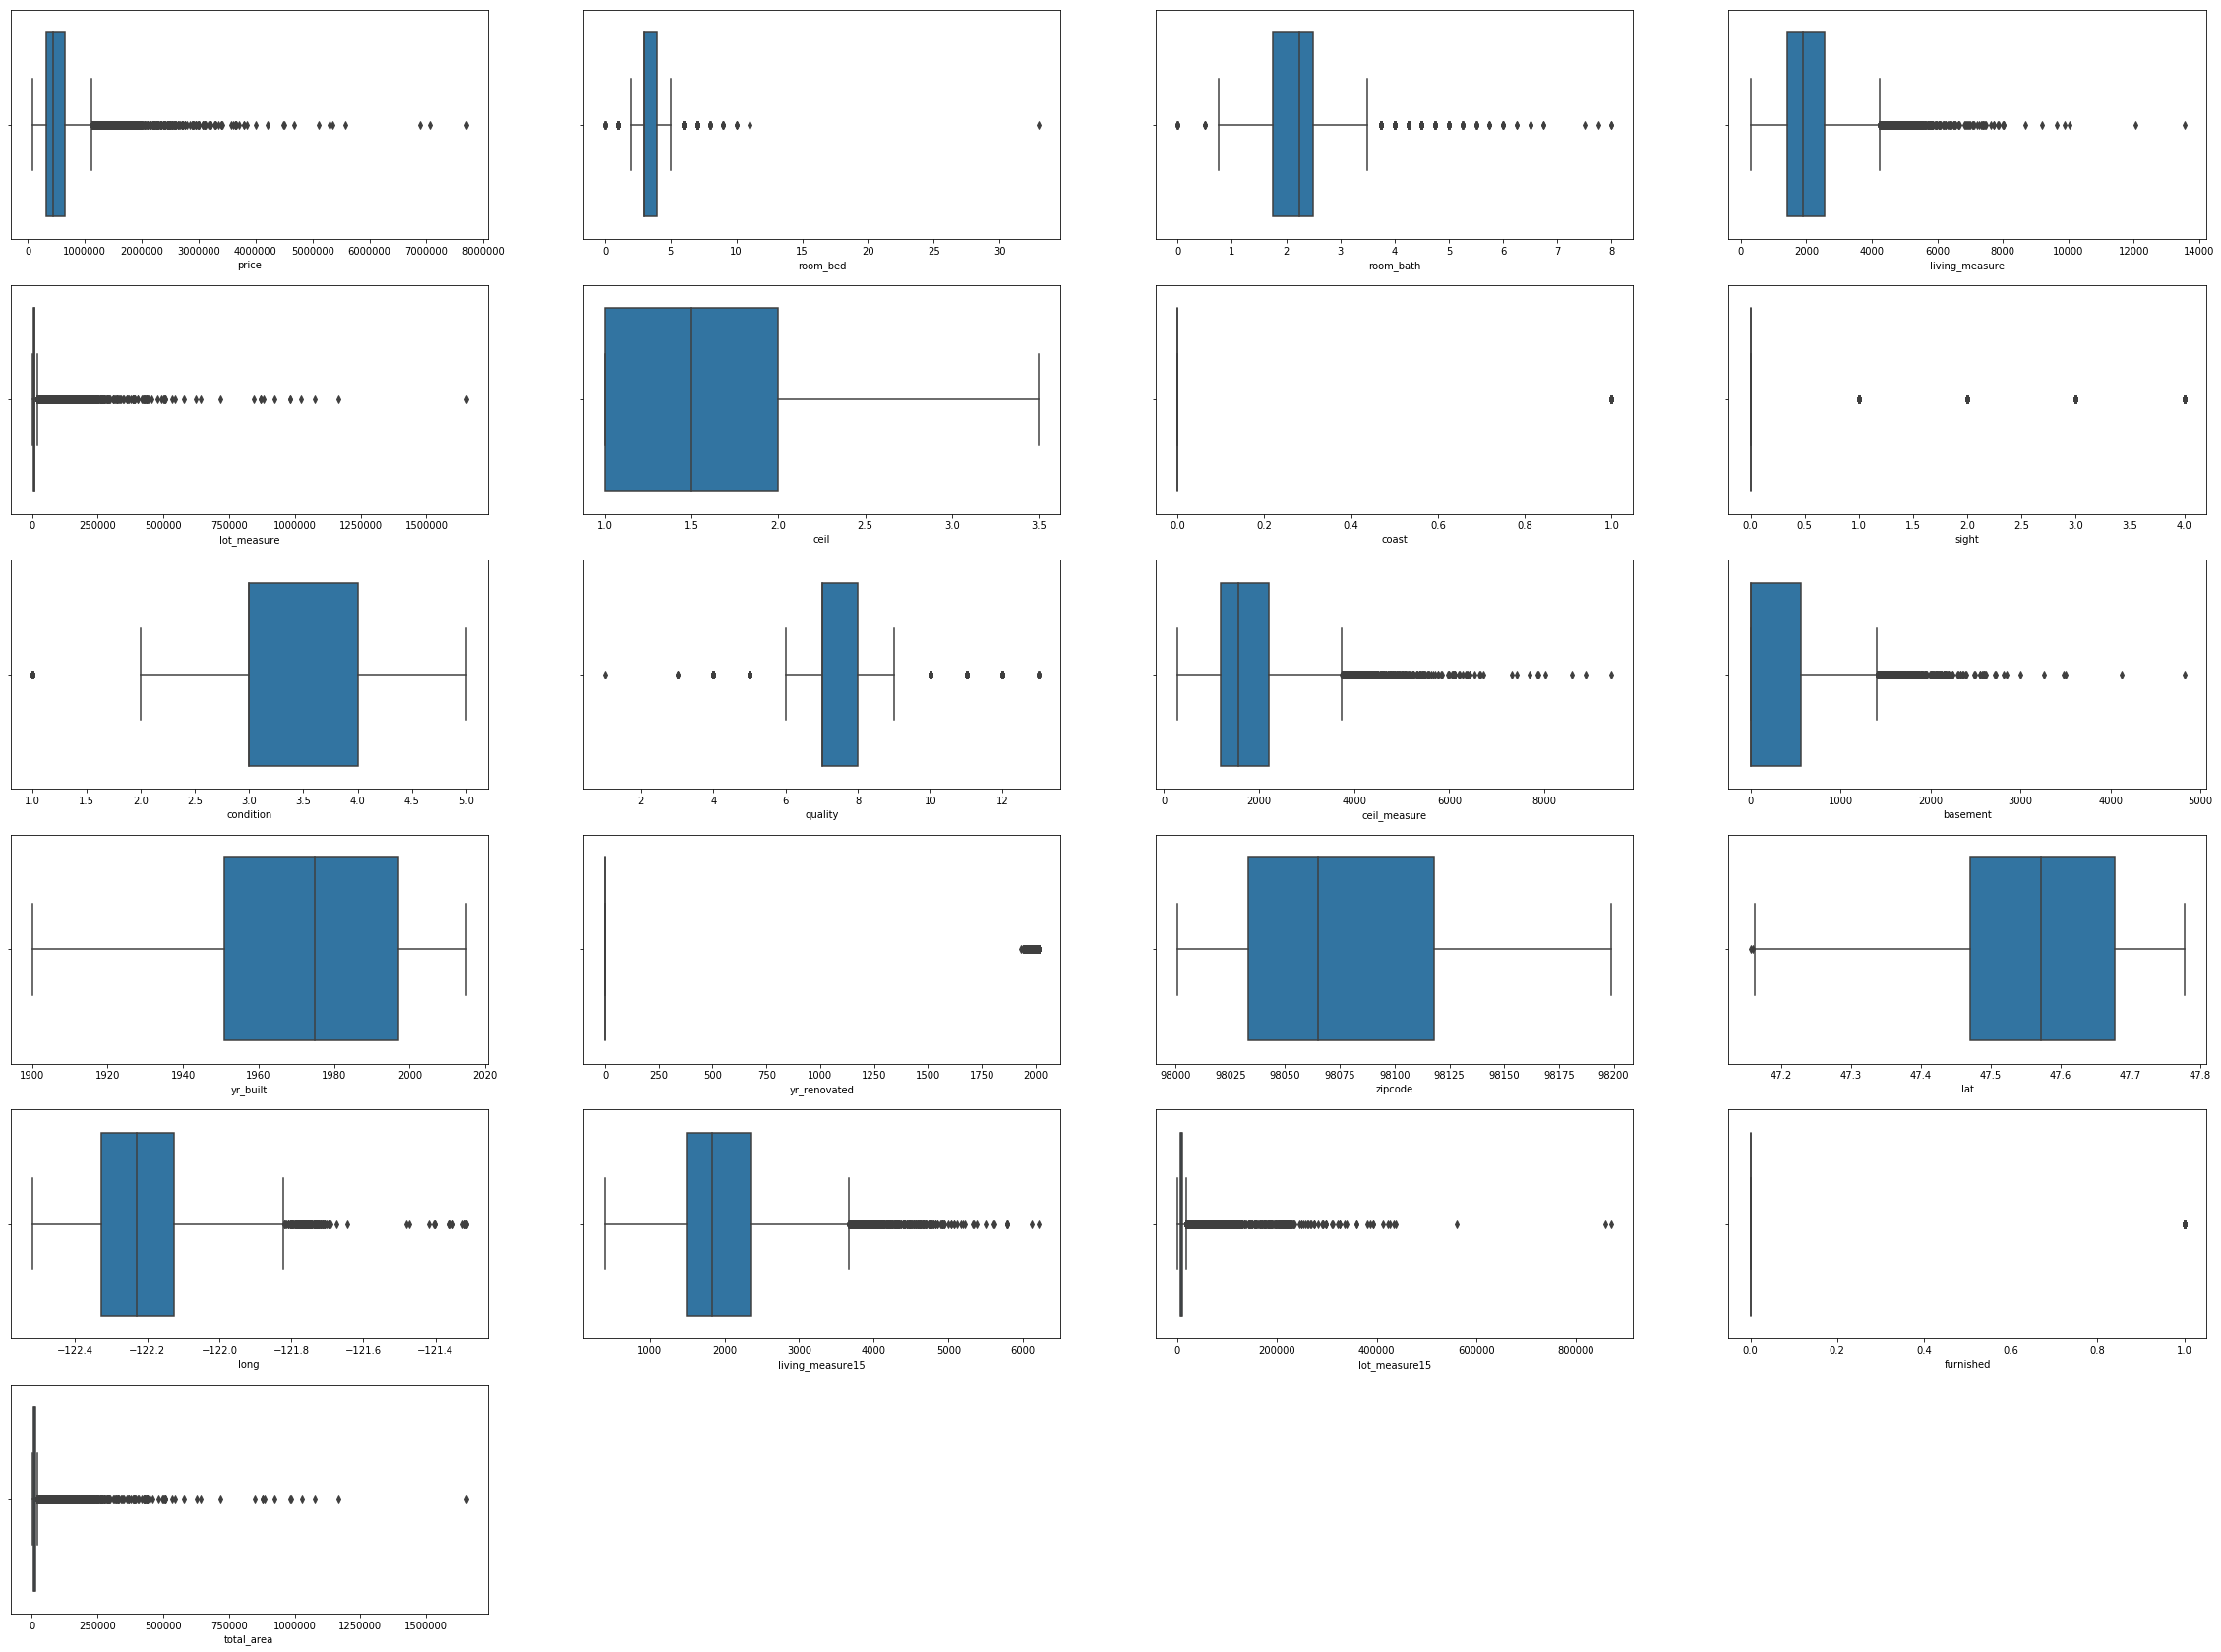

In [1267]:
# visualising presence of outliers using Box Plot
plot_distribution(houses_df, houses_df.columns, plot_type='Box Plot')

In [1268]:
# Additional info where 90 percentile values and outlier count on either side on the median are available
get_additional_info(houses_df, houses_df.columns)

,90%,Percentage,outlier_count_low,outlier_count_high
price,887000.0000,0.900014,0,1159
room_bed,4.0000,0.910471,212,334
room_bath,3.0000,0.913154,14,557
living_measure,3250.0000,0.900014,0,572
lot_measure,21397.6000,0.899968,0,2425
ceil,2.0000,0.963818,0,0
coast,0.0000,0.992458,0,163
sight,0.0000,0.901726,0,2124
condition,4.0000,0.921297,30,0
quality,9.0000,0.924305,275,1636


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 2880x2160 with 0 Axes>

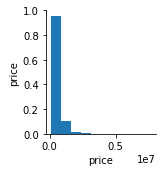

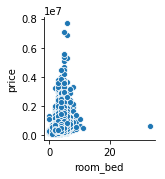

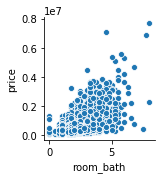

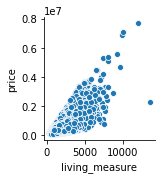

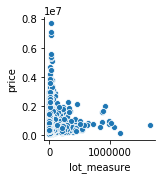

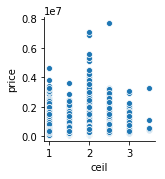

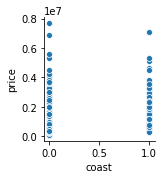

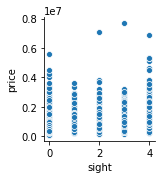

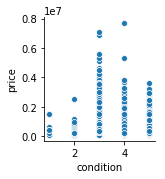

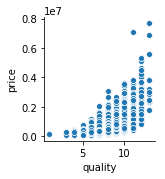

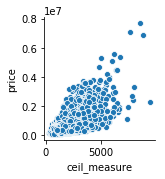

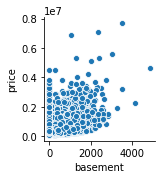

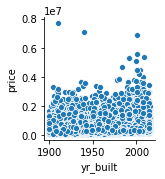

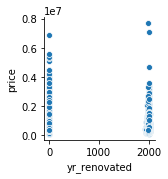

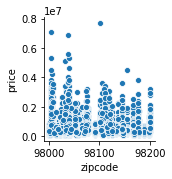

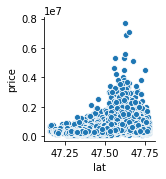

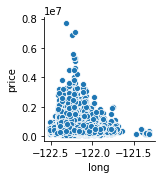

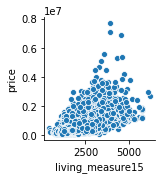

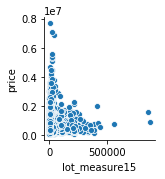

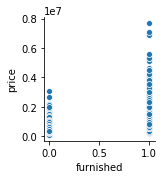

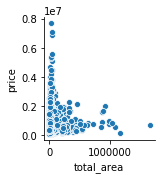

In [1269]:
# Pair plot to identify relationship of different features with Price(target variable)
plot_distribution(houses_df, houses_df.columns, plot_type='Pair Plot', target_column="price")

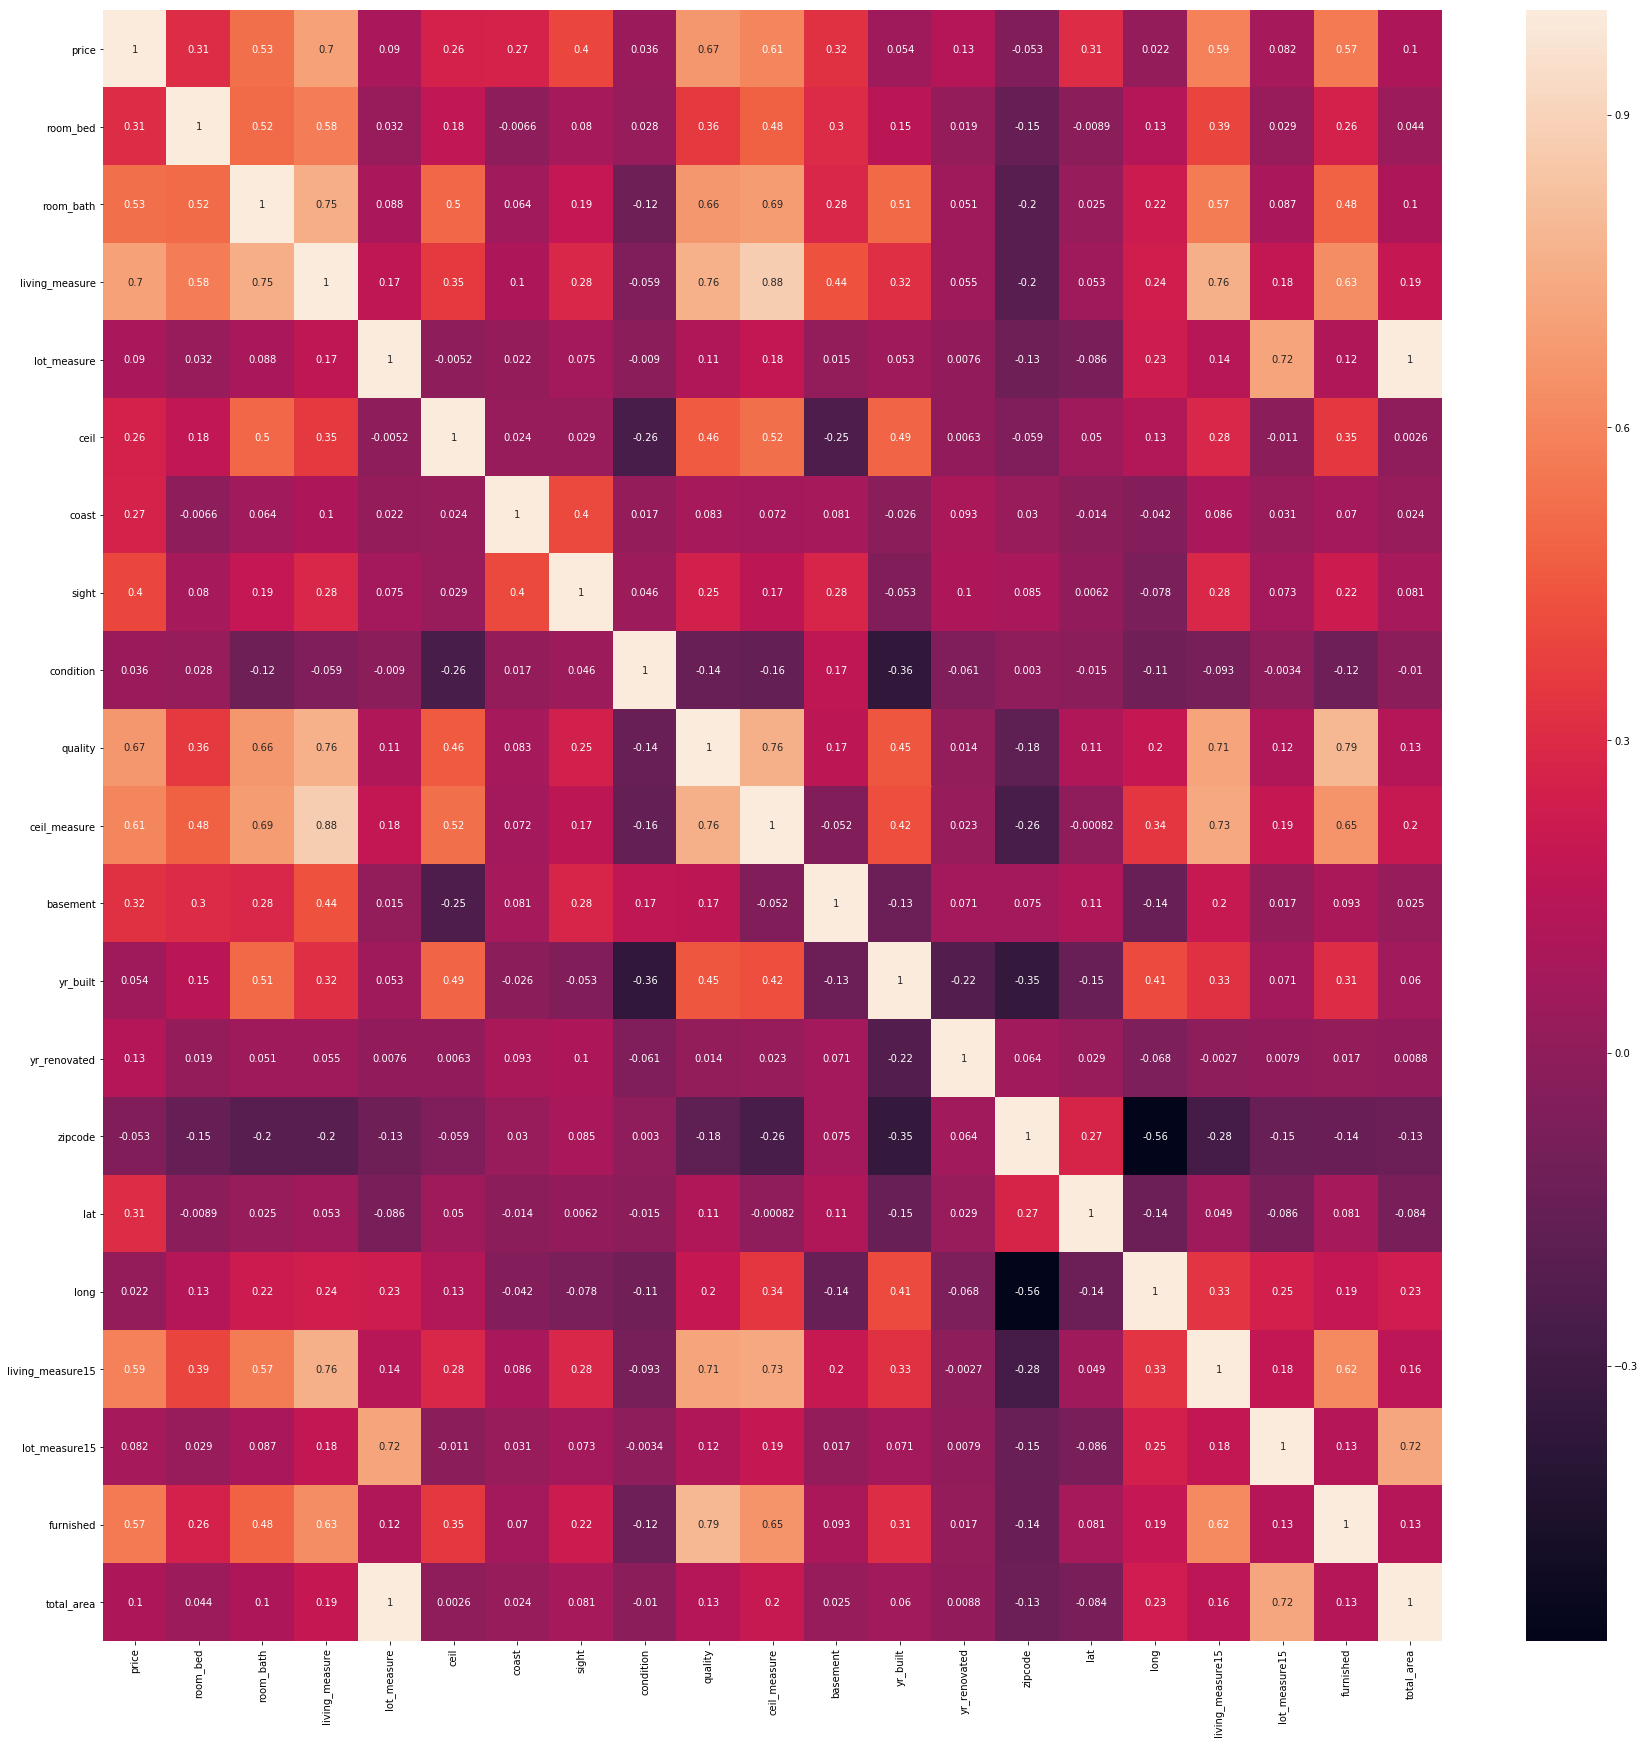

In [1270]:
# Correlation heatmap to visualise the correlation between different variables
plt.figure(figsize= (30,30))
sns.heatmap(houses_df.corr(), annot=True)

#### Check for Multicollinearity

In [1271]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = ["{:.2f}".format(variance_inflation_factor(X.values, i)) for i in range(X.shape[1])]

    return(vif)

In [1272]:
houses_df_vif = houses_df.iloc[:,:-1]
calculate_vif(houses_df_vif)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,price,10.56
1,room_bed,23.72
2,room_bath,29.03
3,living_measure,inf
4,lot_measure,2.38
5,ceil,16.90
6,coast,1.28
7,sight,1.60
8,condition,34.98
9,quality,221.08


There are few features with vif more than 10, in some cases infinity, therefore, multicollinearity exists in the data which would cause few regression models to perform poorly on this data as the assumption of variable independence no longer holds true.

#### Additional analysis on important features

In [1273]:
outlier_data_low, outlier_data_high, lower_cap, upper_cap = get_outlier_data(houses_df)

In [1274]:
def get_additional_analysis(data, outlier_data, column, output_cols, op='mean'):
    filter_index = outlier_data[outlier_data[column].isna() != True].index
    outlier_df = data.loc[filter_index]
    if(op == 'count'):
        return outlier_df.groupby(by=column).count()[output_cols]
    else:
        return outlier_df.groupby(by=column).mean()[output_cols]

Additional analysis on room_bed feature

In [1275]:
# Checking for outlier presence in the room_bed feature towards the lower side of the median
get_additional_analysis(houses_df, outlier_data_low, 'room_bed', ['price', 'living_measure', 'quality'])

,price,living_measure,quality
room_bed,,,
0,410223.076923,1707.846154,6.692308
1,317657.959799,884.613065,6.100503


In [1276]:
# Checking for outlier presence in the room_bed feature towards the higher side of the median
get_additional_analysis(houses_df, outlier_data_high, 'room_bed', ['price', 'living_measure', 'quality'])

,price,living_measure,quality
room_bed,,,
6,8.258535e+05,3284.341912,8.080882
7,9.514478e+05,3974.210526,8.447368
8,1.105077e+06,3800.000000,8.076923
9,8.939998e+05,3775.000000,7.833333
10,8.200000e+05,3706.666667,7.666667
11,5.200000e+05,3000.000000,7.000000
33,6.400000e+05,1620.000000,7.000000


In [1277]:
# Checking the variation of Price, Living measure and Quality across different category in terms of number of bedrooms
# This is to check whether the outlier are true outlier or incorrect data
houses_df.groupby(by='room_bed').mean()[['price', 'living_measure', 'quality']]

,price,living_measure,quality
room_bed,,,
0,4.102231e+05,1707.846154,6.692308
1,3.176580e+05,884.613065,6.100503
2,4.013877e+05,1239.752899,6.871739
3,4.662766e+05,1805.837235,7.472516
4,6.355647e+05,2554.649666,8.116681
5,7.868741e+05,3047.545284,8.272330
6,8.258535e+05,3284.341912,8.080882
7,9.514478e+05,3974.210526,8.447368
8,1.105077e+06,3800.000000,8.076923


In [1278]:
get_additional_analysis(houses_df, outlier_data_high, 'room_bed', ['price'], 'count')

,price
room_bed,
6,272
7,38
8,13
9,6
10,3
11,1
33,1


Additional analysis on room_bath

In [1279]:
# Checking for outlier presence in the room_bath feature towards the lower side of the median
get_additional_analysis(houses_df, outlier_data_low, 'room_bath', ['price', 'living_measure', 'quality'])

,price,living_measure,quality
room_bath,,,
0.0,449095.0,1636.8,6.30
0.5,237375.0,1235.0,6.25


In [1280]:
# Checking for outlier presence in the room_bath feature towards the higher side of the median
get_additional_analysis(houses_df, outlier_data_high, 'room_bath', ['price', 'living_measure', 'quality'])

,price,living_measure,quality
room_bath,,,
3.75,1.198179e+06,3779.741935,9.470968
4.00,1.268405e+06,4071.867647,9.698529
4.25,1.526653e+06,4609.329114,10.088608
4.50,1.334211e+06,4405.940000,9.710000
4.75,2.022300e+06,5275.652174,10.434783
5.00,1.674167e+06,4851.857143,10.142857
5.25,1.817962e+06,5016.153846,10.230769
5.50,2.522500e+06,6506.000000,11.500000
5.75,2.492500e+06,6962.500000,11.250000


In [1281]:
get_additional_analysis(houses_df, outlier_data_high, 'quality', ['price', 'living_measure'])

,price,living_measure
quality,,
10,1.072347e+06,3520.299824
11,1.497792e+06,4395.448622
12,2.192500e+06,5471.588889
13,3.710769e+06,7483.076923


In [1282]:
get_additional_analysis(houses_df, outlier_data_high, 'quality', ['price', 'living_measure'], op='count')

,price,living_measure
quality,,
10,1134,1134
11,399,399
12,90,90
13,13,13


In [1283]:
get_additional_analysis(houses_df, outlier_data_low, 'quality', ['price', 'living_measure'])

,price,living_measure
quality,,
1,142000.000000,290.000000
3,205666.666667,596.666667
4,214381.034483,660.482759
5,248523.971074,983.326446


In [1284]:
get_additional_analysis(houses_df, outlier_data_low, 'quality', ['price', 'living_measure'], op='count')

,price,living_measure
quality,,
1,1,1
3,3,3
4,29,29
5,242,242


In [1285]:
houses_df[houses_df.furnished == 0]['furnished'].count() /  houses_df['furnished'].count()

0.8033128209873687

#### Findings and Inferences from EDA

1. Almost all the numerical columns have a right skewed distribution with a long tail due to presence of outliers towards the right
2. room_bath, living_measure, quality, ceil_measure show higher correlation with price
3. outliers in room_bed on the lower side seems to be acceptable values, on the other hand on higher side number of bedroom is increasing with decrease in living area and price, therefore it seems to be an inconsistency in the data
4. Quality has outliers on both side of median (more on the higher side), however the behaviour of price with increase in Quality seems to be consistent
5. Few observations on data distribution:
    1. ~99% of the house do not face water front
    2. ~96% of the houses have 2 or less than 2 floors
    3. ~80% of the houses are not furnished
    4. ~91% of the houses have less than 4 bedrooms
    5. ~8% of the houses have graded more than rating of 9 
    

In [1286]:
houses_df.groupby('coast').mean()['price']

coast
0    5.316534e+05
1    1.662524e+06
Name: price, dtype: float64

In [1287]:
houses_df.groupby('coast').count()['price']

coast
0    21450
1      163
Name: price, dtype: int64

#### Model Building

As the nature of the problem is regression, hence various regression algorithms like LinearRegression, DecisionTreeRegressor, RandomForestRegressor etc. will be suitable for this problem. However, by analysing the data we would prefer ensemble learning algorithms like RandomForestRegressor, GradientBoostingRegressor for this problem. Justification for the algorithm choice is given below:

1. Data has a lot of dependency among the predictors which would give rise to multicollinearity in case of linear models and presence of outliers will further reduce the accuracy of these models
2. Ensemble algorithms do not make any assumptions around the data like assumption of linear relation of variables in case of SVM, also they are relatively inexpensive computationally to SVM.
3. Ensemble learning algorithms performance is not affected a lot by the outliers and noise in data
4. Problem of overfitting can be easily solved by hyperparameter tuning

In conclusion, Ensemble learning algortihms seems to be the most suitable algorithms for the given problem and dataset.

In [1288]:
def get_model_accuracy_results(models, x_train, y_train, x_test, y_test):
    results = {}
    for (key, value) in models.items():
        model, train_score, test_score = get_model_accuracy(value, x_train, y_train, x_test, y_test)
        results[key] = [model, train_score, test_score]
    
    return results

def get_model_accuracy(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    return model, train_score, test_score

In [1289]:
X = houses_df.drop(columns = 'price')
Y = houses_df.price

In [1290]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [1291]:
# Initialising different models with default parameters 
# as optimal values of patameters will be set as part of hyper parameter tuning
lr = LinearRegression()
dTree_reg = DecisionTreeRegressor()
rf_regressor = RandomForestRegressor(random_state=1)
adaboost_reg = AdaBoostRegressor(base_estimator=dTree_reg, random_state=1)
bagging_reg = BaggingRegressor(base_estimator=dTree_reg, random_state=1)
gradBoost_reg = GradientBoostingRegressor(random_state=1)

In [1292]:
models = {'LinearRegression' : lr, 'DecisionTreeRegressor': dTree_reg, 'RandomForestRegressor': rf_regressor, 
          'AdaBoostRegressor': adaboost_reg, 'BaggingRegressor': bagging_reg, 'GradientBoostingRegressor': gradBoost_reg}

In [1293]:
model_outputs = get_model_accuracy_results(models, x_train, y_train, x_test, y_test)

In [1294]:
pd.DataFrame(model_outputs.values(), index=model_outputs.keys(), columns=['Model', 'Train Score', 'Test Score'])

,Model,Train Score,Test Score
LinearRegression,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.700548,0.699730
DecisionTreeRegressor,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",0.999286,0.771166
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.982274,0.884080
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.997900,0.885799
BaggingRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.975205,0.871961
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.900505,0.867844


In [1295]:
gradBoost_reg = model_outputs['GradientBoostingRegressor'][0]

In [1296]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", gradBoost_reg.feature_importances_[i] * 100)

room_bed : 0.05451422868194124
room_bath : 0.6826729920432819
living_measure : 29.297776984557533
lot_measure : 0.1154108815116557
ceil : 0.015743248563367857
coast : 4.554800487855531
sight : 2.568031355795542
condition : 0.23676225075387577
quality : 31.137024426461107
ceil_measure : 1.3873174722186548
basement : 0.13327682790843964
yr_built : 2.903800707008279
yr_renovated : 0.17649424612958906
zipcode : 1.4599536261757735
lat : 15.667673259499661
long : 6.378819646507145
living_measure15 : 2.901079864913027
lot_measure15 : 0.15984309136575034
furnished : 0.00715279565000349
total_area : 0.1618516063998157


1. All the above models except GradientBoostingRegressor have problem of overfitting on training data which can be rectified with hyperparameter tuning. 
2. AdaBoostRegressor(with DecisionTree as the base estimator) is giving the higest accuracy of ~89% on test set, however to compare the models cross-validation would be done at the later stages.
2. RandomForestRegressor results in similar accuracy(~88%) as AdaBoostRegressor
3. Based on initial performance, GradientBoostingRegressor seems to be more generalised and has good prediction accuracy on both Train and Test set. 

We will use GradientBoostingRegressor as the base model to understand the impact of Feature Engineering and outlier treatment. We will also check how the next steps affect RandomForestRegressor and AdaBoostRegressor performace. However in later stages, we will compare the model scores by cross-validation techniques and finalize a model for prediction. 

### Outlier Treatment

In [1297]:
def replace_outliers_from_df(data, columns, lower_cap, upper_cap, to_replace='all'):
    '''
    Replaces outlier present in the columns provided as input
    to_replace: outliers to replaced on which side or all, possible values {lower, upper, all}
    '''
    modified_data = data.copy()
    for col in columns:
        if((to_replace.lower() == 'lower') | (to_replace.lower() == 'all')):
            modified_data[col] = np.where((data[col] <= lower_cap[col]), max(lower_cap[col], data[col].min()), modified_data[col]) 
            
        if((to_replace.lower() == 'upper') | (to_replace.lower() == 'all')):
            modified_data[col] = np.where((data[col] >= upper_cap[col]), min(upper_cap[col], data[col].max()), modified_data[col]) 
        
    return modified_data

In [1298]:
outlier_cols = ['room_bed', 'room_bath', 'ceil_measure', 'living_measure', 'total_area']

In [1299]:
# Replacing outlier in the selected columns and only towards the higher end based on analysis done earlier
x_train = replace_outliers_from_df(x_train, outlier_cols, lower_cap, upper_cap, to_replace='upper')

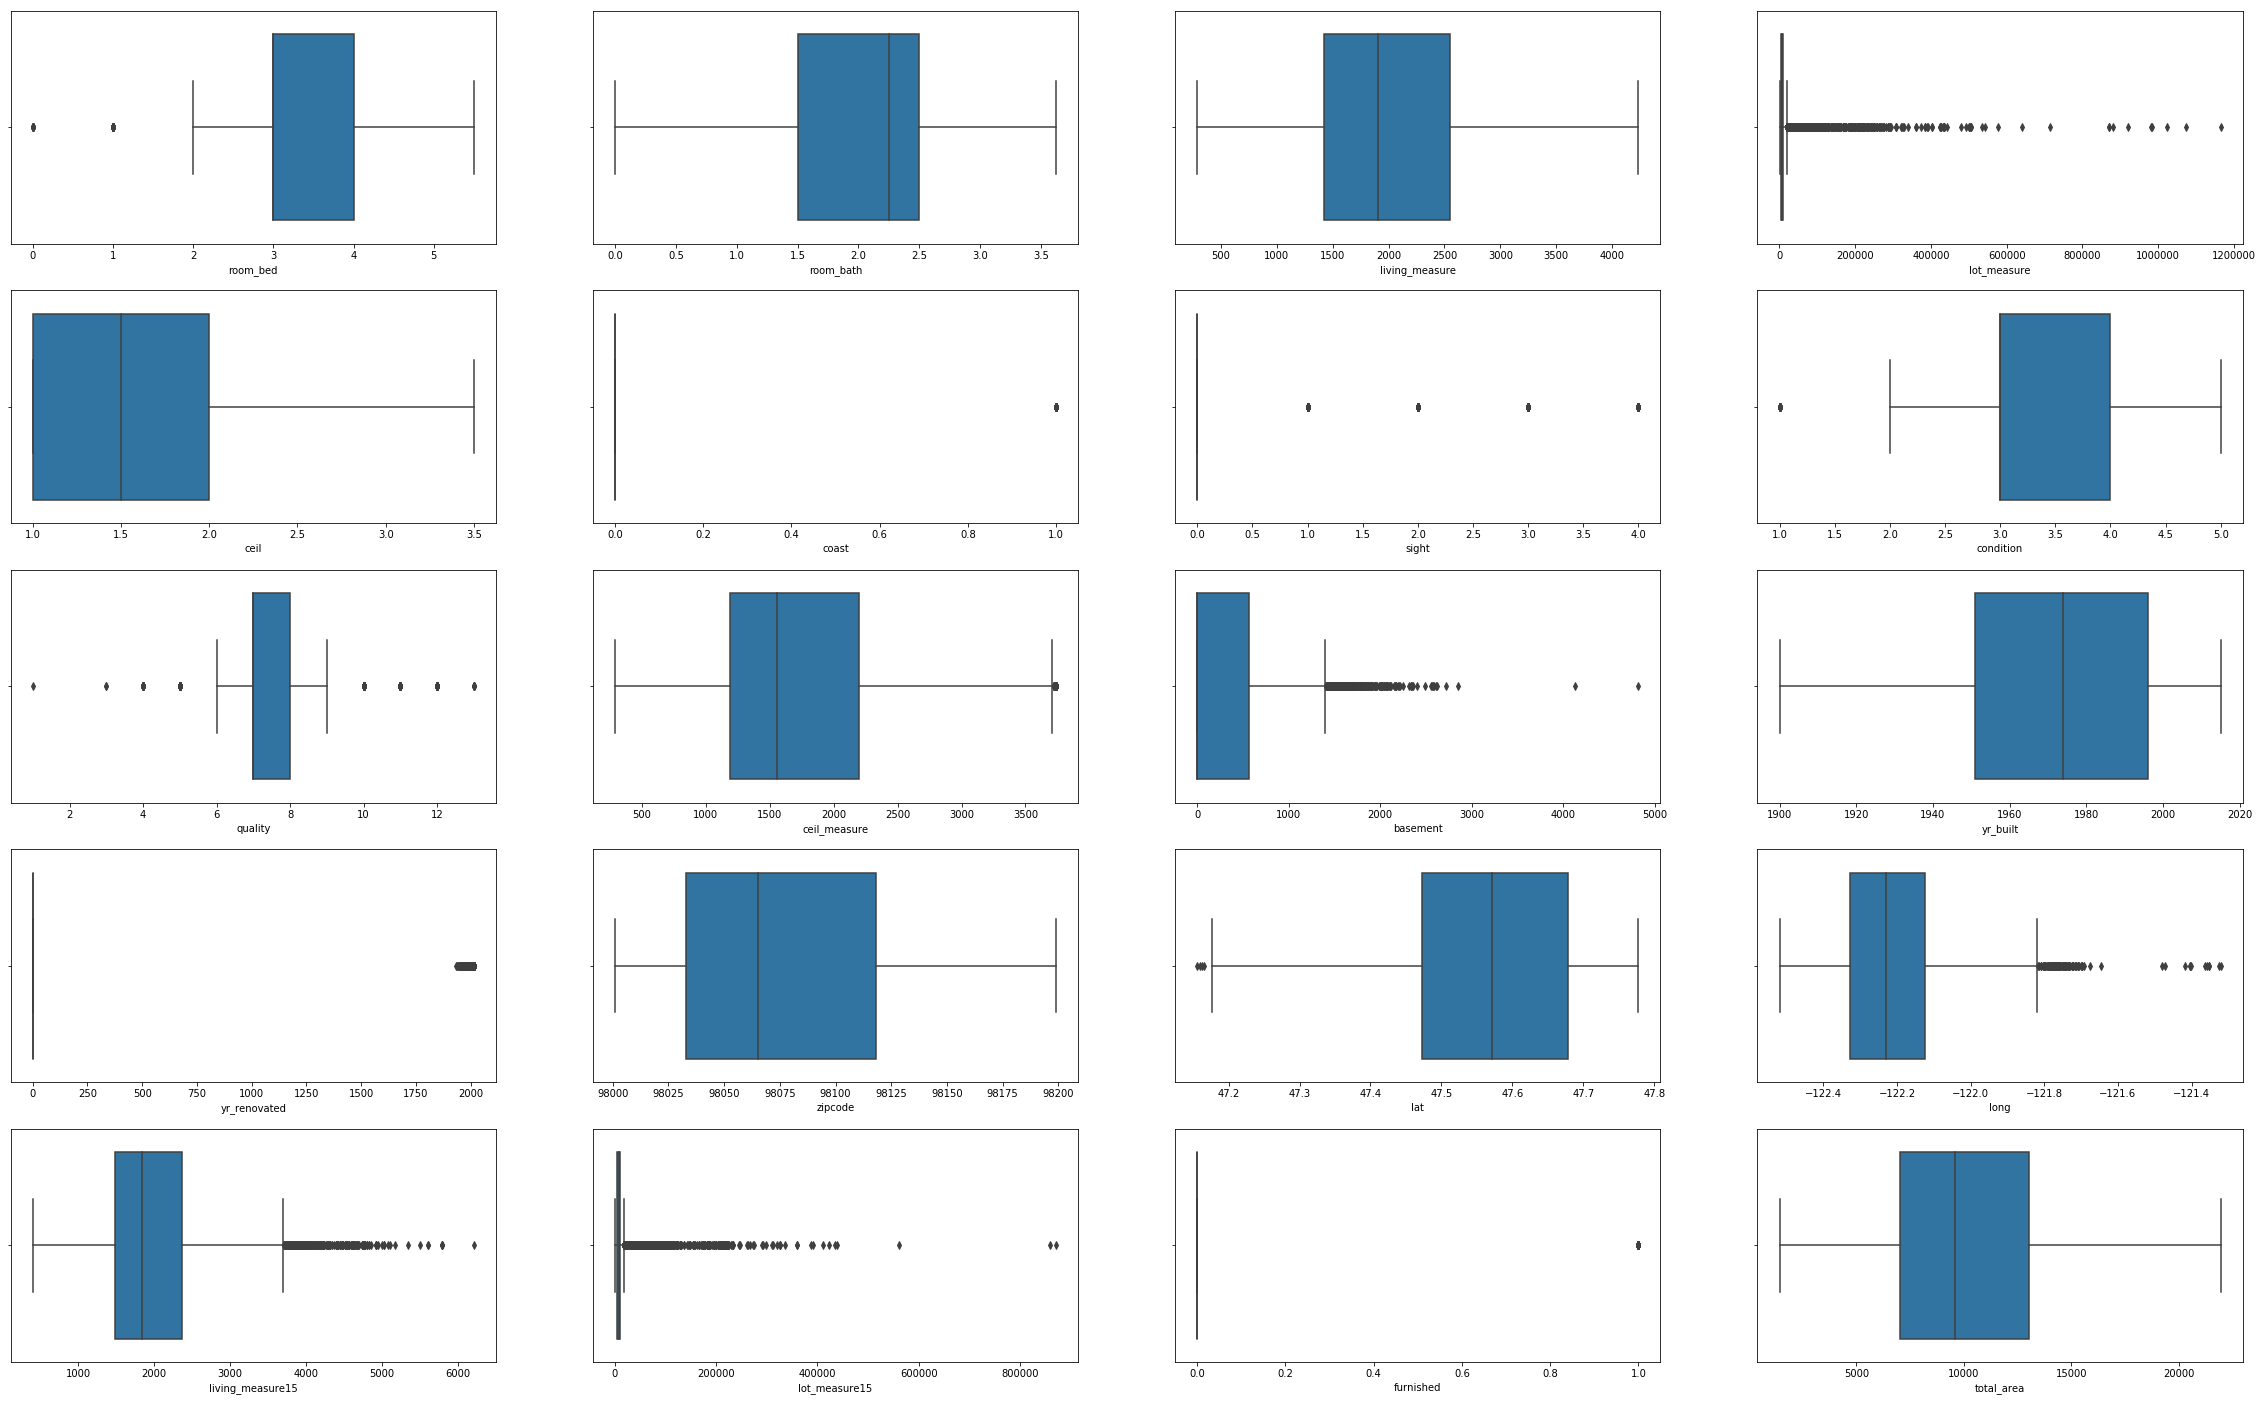

In [1300]:
# visualising presence of outliers using Box Plot
plot_distribution(x_train, x_train.columns, plot_type='Box Plot')

In [1301]:
models = {'RandomForestRegressor': rf_regressor, 'AdaBoostRegressor': adaboost_reg, 'GradientBoostingRegressor': gradBoost_reg}

In [1302]:
model_outputs = get_model_accuracy_results(models, x_train, y_train, x_test, y_test)

In [1303]:
pd.DataFrame(model_outputs.values(), index=model_outputs.keys(), columns=['Model', 'Train Score', 'Test Score'])

,Model,Train Score,Test Score
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.981515,0.873903
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.998336,0.856691
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.896449,0.861200


In [1304]:
gradBoost_reg = model_outputs['GradientBoostingRegressor'][0]

In [1305]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", gradBoost_reg.feature_importances_[i] * 100)

room_bed : 0.01756398878491094
room_bath : 0.904254360954235
living_measure : 25.941127999753032
lot_measure : 0.27038576655238766
ceil : 0.009183052422002102
coast : 4.952479137120003
sight : 3.0929045862128213
condition : 0.2456516353424638
quality : 25.62725383551827
ceil_measure : 0.5905051136394991
basement : 0.45025074847068564
yr_built : 3.2766613918449794
yr_renovated : 0.13399997686712556
zipcode : 1.9315798025642898
lat : 16.034524756760955
long : 6.811442650373436
living_measure15 : 2.8604532429825724
lot_measure15 : 0.2762122435800651
furnished : 6.418376808722279
total_area : 0.15518890153397233


On outlier treatment, we can see that data distribution has improved without losing much accuracy in prediction.

### Feature Engineering

In [1306]:
def get_models_output(data, models, outlier_cols, replace_outlier=True):
    X = data.drop(columns = 'price')
    Y = data.price
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, shuffle=True)
    # Replacing outlier from train set in the selected columns and only towards the higher end based on our observations
    if(replace_outlier):
        x_train = replace_outliers_from_df(x_train, outlier_cols, lower_cap, upper_cap, to_replace='upper')
    
    model_outputs = get_model_accuracy_results(models, x_train, y_train, x_test, y_test)
    model_outputs_df = pd.DataFrame(model_outputs.values(), index=model_outputs.keys(), columns=['Model', 'Train Score', 'Test Score'])
    return model_outputs_df, x_train, x_test, y_train, y_test


def get_models_output_from_train_test_set(models, x_train, y_train, x_test, y_test):
    model_outputs = get_model_accuracy_results(models, x_train, y_train, x_test, y_test)
    model_outputs_df = pd.DataFrame(model_outputs.values(), index=model_outputs.keys(), columns=['Model', 'Train Score', 'Test Score'])
    return model_outputs_df

In [1307]:
# Converting object feature dayhours to numerical value by calculating age in years of the house at the time it was sold
# dayhours can be dropped and replaced by the new feature age_years
houses_df.reset_index(level=1, inplace=True)

def get_years_from_dayhours(dayhours, year_built, year_renovated):
    dayhour_date = datetime.strptime(dayhours.split("T")[0], "%Y%m%d")
    if(year_renovated == 0):
        return dayhour_date.date().year - year_built
    else:
        return dayhour_date.date().year - year_renovated

houses_df["age_years"] = houses_df.apply(lambda x : get_years_from_dayhours(x["dayhours"], x["yr_built"], x["yr_renovated"]), axis=1)
houses_df.drop(columns = 'dayhours', inplace=True)
houses_df.head()

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,...,yr_built,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area,age_years
cid,,,,,,,,,,,,,,,,,,,,,
3034200666,808100,4,3.25,3020,13457,1.0,0,0,5,9,...,1956,0,98133,47.7174,-122.336,2120,7553,1,16477,58
8731981640,277500,4,2.50,2550,7500,1.0,0,0,3,8,...,1976,0,98023,47.3165,-122.386,2260,8800,0,10050,38
5104530220,404000,3,2.50,2370,4324,2.0,0,0,3,8,...,2006,0,98038,47.3515,-121.999,2370,4348,0,6694,9
6145600285,300000,2,1.00,820,3844,1.0,0,0,4,6,...,1916,0,98133,47.7049,-122.349,1520,3844,0,4664,98
8924100111,699000,2,1.50,1400,4050,1.0,0,0,4,8,...,1954,0,98115,47.6768,-122.269,1900,5940,0,5450,61


In [1308]:
model_outputs, x_train, x_test, y_train, y_test = get_models_output(houses_df, models, outlier_cols, replace_outlier=False)
model_outputs

,Model,Train Score,Test Score
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.982638,0.882187
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.999699,0.888520
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.899324,0.869276


In [1309]:
# Utilising the feature lat and long by calculating euclidean distance from a reference point
# For this purpose we have chosen centroid (mean of lat, mean of long) as the reference point

def get_euclidean_distance(lat, long, reference = (0,0)):
    return ((lat - reference[0])**2 + (long - reference[0])**2)**0.5

reference_point = (houses_df.lat.mean(), houses_df.long.mean())
houses_df["distance"] = houses_df.apply(lambda x : get_euclidean_distance(x["lat"], x["long"]), axis=1)
houses_df.head()

,price,room_bed,room_bath,living_measure,lot_measure,ceil,coast,sight,condition,quality,...,yr_renovated,zipcode,lat,long,living_measure15,lot_measure15,furnished,total_area,age_years,distance
cid,,,,,,,,,,,,,,,,,,,,,
3034200666,808100,4,3.25,3020,13457,1.0,0,0,5,9,...,0,98133,47.7174,-122.336,2120,7553,1,16477,58,131.312784
8731981640,277500,4,2.50,2550,7500,1.0,0,0,3,8,...,0,98023,47.3165,-122.386,2260,8800,0,10050,38,131.214268
5104530220,404000,3,2.50,2370,4324,2.0,0,0,3,8,...,0,98038,47.3515,-121.999,2370,4348,0,6694,9,130.866040
6145600285,300000,2,1.00,820,3844,1.0,0,0,4,6,...,0,98133,47.7049,-122.349,1520,3844,0,4664,98,131.320354
8924100111,699000,2,1.50,1400,4050,1.0,0,0,4,8,...,0,98115,47.6768,-122.269,1900,5940,0,5450,61,131.235611


In [1310]:
model_outputs, x_train, x_test, y_train, y_test = get_models_output(houses_df, models, outlier_cols, replace_outlier=False)
model_outputs

,Model,Train Score,Test Score
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.982465,0.883458
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.999698,0.889572
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.902971,0.875446


<Figure size 2880x2160 with 0 Axes>

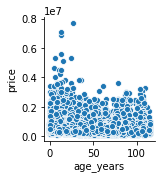

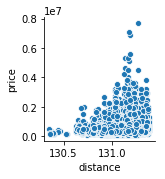

In [1311]:
# Pair plot to identify relationship of different features with Price(target variable)
plot_distribution(houses_df, ['age_years', 'distance'], plot_type='Pair Plot', target_column="price")

In [1312]:
# Dropping features based on the feature importance
houses_df.drop(columns = ['ceil', 'lot_measure', 'lot_measure15', 'basement', 'condition',
                          'total_area', 'yr_renovated', 'room_bed', 'room_bath', 'ceil_measure'], inplace=True)

In [1313]:
houses_df.shape

(21613, 13)

In [1314]:
model_outputs, x_train, x_test, y_train, y_test = get_models_output(houses_df, models, outlier_cols, replace_outlier=False)

In [1315]:
model_outputs

,Model,Train Score,Test Score
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.982679,0.881847
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.999659,0.880091
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.898998,0.874162


In [1316]:
gradBoost_reg = model_outputs['Model'][2]

In [1317]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", gradBoost_reg.feature_importances_[i] * 100)

living_measure : 31.041546640863913
coast : 4.6683108621971074
sight : 2.4247218198607143
quality : 30.26172704421135
yr_built : 2.927860483802952
zipcode : 1.6493136997606919
lat : 15.646576104927174
long : 4.403264201543587
living_measure15 : 2.707885837391201
furnished : 1.1933637217564925
age_years : 0.3496680884787267
distance : 2.725761495206095


In [1318]:
rf_regressor = model_outputs['Model'][0]

In [1319]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", rf_regressor.feature_importances_[i] * 100)

living_measure : 27.34298845852588
coast : 3.1305985336098017
sight : 2.0452890844928047
quality : 19.579497286884113
yr_built : 2.4976326257089543
zipcode : 1.6528551230598871
lat : 16.590194828837504
long : 5.891916441573247
living_measure15 : 4.043636950156447
furnished : 12.63038564528944
age_years : 1.383752296022226
distance : 3.211252725839705


In [1320]:
adaboost_reg = model_outputs['Model'][1]

In [1321]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", adaboost_reg.feature_importances_[i] * 100)

living_measure : 48.08134820208173
coast : 5.992339888256755
sight : 1.5848864198460537
quality : 18.79010308785872
yr_built : 1.5335742971226547
zipcode : 2.0149477276251497
lat : 6.369814588093154
long : 4.469372917442954
living_measure15 : 3.1004078808897306
furnished : 3.3653760882352697
age_years : 1.3238552582113392
distance : 3.373973644336515


### Upsampling the data

In [1392]:
# Merging training set X and Y to create data for upsampling 
houses_data_sampled = x_train.merge(y_train, on=x_train.index, how='left', left_index=True)
houses_data_sampled.drop(columns=['key_0'], inplace=True)
houses_data_sampled.shape

(15331, 13)

In [1393]:
houses_data_sampled.head()

,living_measure,coast,sight,quality,yr_built,zipcode,lat,long,living_measure15,furnished,age_years,distance,price
cid,,,,,,,,,,,,,
9547205660,1700,0,0,7,1926,98115,47.6819,-122.311,1500,0,89,131.276595,603000
4054530210,3560,0,0,11,1992,98077,47.7268,-122.050,3520,1,23,131.049799,896000
1423089118,1790,0,0,7,1983,98045,47.4819,-121.744,2060,0,32,130.675676,494000
9268851800,1620,0,0,8,2010,98027,47.5401,-122.027,1620,0,4,130.960490,415000
811000050,1890,0,0,9,1929,98109,47.6312,-122.353,2560,1,85,131.297326,826000


In [1394]:
# Filtering the minority and majority data
minority_df = houses_data_sampled[houses_data_sampled.furnished == 1]
majority_df = houses_data_sampled[houses_data_sampled.furnished == 0]

In [1395]:
print(len(majority_df))
print(len(minority_df))

12346
2985


For a 60-40 proportion of furnished 0 and 1, we need to add 8220 records with coast = 1

In [1396]:
# Upsampling the data to achieve 60-40 proportion for coast feature
minority_df_upsampled = resample(minority_df, 
                                 replace=True,     
                                 n_samples=8220,    
                                 random_state=1)

In [1397]:
# Upsampled data by merging majority data with upsampled minority data
houses_df_sampled = pd.concat([majority_df, minority_df_upsampled])

In [1398]:
houses_df_sampled.shape[0]

20566

In [1399]:
# %distribution of minority and mojority values post upsampling
print('Coast_0 : ', len(majority_df), '(', len(majority_df)/ len(houses_df_sampled), ')')
print('Coast_1 : ', len(minority_df_upsampled), '(', len(minority_df_upsampled)/ len(houses_df_sampled), ')')

Coast_0 :  12346 ( 0.6003111932315472 )
Coast_1 :  8220 ( 0.3996888067684528 )


In [1400]:
# creating training dataset
x_train_sampled = houses_df_sampled.drop(columns = 'price')
y_train_sampled = houses_df_sampled.price

In [1401]:
model_outputs = get_model_accuracy_results(models, x_train_sampled, y_train_sampled, x_test, y_test)

In [1402]:
pd.DataFrame(model_outputs.values(), index=model_outputs.keys(), columns=['Model', 'Train Score', 'Test Score'])

,Model,Train Score,Test Score
RandomForestRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.995443,0.869356
AdaBoostRegressor,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.998543,0.863537
GradientBoostingRegressor,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.915821,0.866436


#### Feature importance

In [1333]:
gradBoost_reg = model_outputs['GradientBoostingRegressor'][0]

In [1334]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", gradBoost_reg.feature_importances_[i] * 100)

living_measure : 37.58380043540251
coast : 3.8742673991477745
sight : 2.192313996843817
quality : 23.939825855967474
yr_built : 2.5018137178035826
zipcode : 1.6601000041591663
lat : 13.347019971550612
long : 4.3658695712306965
living_measure15 : 2.1143672577223103
furnished : 3.6191914212172454
age_years : 0.7916774422820932
distance : 4.00975292667275


In [1335]:
rf_regressor = model_outputs['RandomForestRegressor'][0]

In [1336]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", rf_regressor.feature_importances_[i] * 100)

living_measure : 29.37003321493701
coast : 2.7145430358512583
sight : 1.5187150934153117
quality : 29.512444178370075
yr_built : 2.872573494400781
zipcode : 2.155597551194019
lat : 12.631550127488666
long : 5.041595070140371
living_measure15 : 3.5023572632758024
furnished : 4.809100511809124
age_years : 1.474908495964735
distance : 4.396581963152853


In [1337]:
adaboost_reg = model_outputs['AdaBoostRegressor'][0]

In [1338]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", adaboost_reg.feature_importances_[i] * 100)

living_measure : 45.097473973857845
coast : 2.5873832940631734
sight : 2.2723581854627426
quality : 23.337016904502487
yr_built : 1.6807268791468304
zipcode : 2.112208711001421
lat : 7.522676426551028
long : 4.57144477852889
living_measure15 : 3.5942191283053133
furnished : 2.487894604003867
age_years : 1.8671392923341092
distance : 2.8694578222422997


Inference -

Upsampling did increase the feature importance for coast feature but didn't improve model performace rather decreased the accuracy of GradientBoosterRegressor and RandomForestRegressor

### Cross Validation

In [1339]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [1340]:
num_folds = 10
kfold = KFold(n_splits=num_folds, random_state=1, shuffle=True)

In [1341]:
def get_mean_cross_val_score(model, X, Y, cv):
    kfold_score = cross_val_score(model, X, Y, cv=cv)
    mean_score = kfold_score.mean() * 100
    std_deviation = kfold_score.std() * 100
    return mean_score, std_deviation

def get_accuracy_for_confidence(mean, std, confidence = 0.95):
    accuracy_confidence_low = (mean - norm.ppf(confidence) * std) 
    accuracy_confidence_high = (mean + norm.ppf(confidence) * std)
    return accuracy_confidence_low, accuracy_confidence_high

In [1342]:
train_df = x_train.merge(y_train, on=x_train.index, how='left', left_index=True)
train_df.drop(columns=['key_0'], inplace=True)

In [1343]:
test_df = x_test.merge(y_test, on=x_test.index, how='left', left_index=True)
test_df.drop(columns=['key_0'], inplace=True)

In [1344]:
house_df_updated = pd.concat([train_df, test_df])

In [1345]:
X_New = house_df_updated.drop(columns=['price'])
Y_New = house_df_updated['price']

In [1346]:
mean_accuracy, std_deviation = get_mean_cross_val_score(rf_regressor, X_New, Y_New, kfold)

In [1347]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation)
print("Mean Accuracy: %.2f%%" % (mean_accuracy))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

Mean Accuracy: 87.78%
95% confidence level Model performance range is from 86.10% to 89.46%


In [1348]:
mean_accuracy, std_deviation = get_mean_cross_val_score(adaboost_reg, X_New, Y_New, kfold)

In [1349]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation)
print("Mean Accuracy: %.2f%%" % (mean_accuracy))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

Mean Accuracy: 87.56%
95% confidence level Model performance range is from 83.93% to 91.19%


In [1350]:
mean_accuracy, std_deviation = get_mean_cross_val_score(gradBoost_reg, X_New, Y_New, kfold)

In [1351]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation)
print("Mean Accuracy: %.2f%%" % (mean_accuracy))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

Mean Accuracy: 86.49%
95% confidence level Model performance range is from 84.36% to 88.61%


### Hyperparameter Tuning

#### RandomForestRegressor

In [1352]:
from time import time
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [1353]:
param_dist = {"n_estimators": [50, 70, 100],
              "max_depth": randint(5, 10),
              "max_features": ['auto', 0.5, 0.7],
              "min_samples_split": randint(3, 8),
              "bootstrap": [True, False],
              }

In [1354]:
randomCV = RandomizedSearchCV(rf_regressor, param_distributions=param_dist, n_iter=20, cv=3)

In [1355]:
start = time()
randomCV.fit(X_New, Y_New)
elapsed_time = time()-start
print(randomCV.best_params_)
print('Duration :', (elapsed_time/60))

{'bootstrap': True, 'max_depth': 9, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 50}
Duration : 2.611327660083771


In [1356]:
randomCV.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=0.7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [1357]:
best_output = get_model_accuracy_results({'Best Estimator': randomCV.best_estimator_}, x_train, y_train, x_test, y_test)

In [1358]:
pd.DataFrame(best_output.values(), index=best_output.keys(), columns=['Model', 'Train Score', 'Test Score'])

,Model,Train Score,Test Score
Best Estimator,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",0.916703,0.86831


In [1359]:
best_model = best_output['Best Estimator'][0]

In [1360]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", best_model.feature_importances_[i] * 100)

living_measure : 26.54539207957406
coast : 3.1408321797982053
sight : 2.43427180898895
quality : 22.331755861361994
yr_built : 2.3535580041709263
zipcode : 1.356747603788176
lat : 14.89381218951581
long : 4.650627352692688
living_measure15 : 3.7452933102639507
furnished : 14.264586945810953
age_years : 0.780761488743125
distance : 3.50236117529117


In [1361]:
mean_accuracy, std_deviation = get_mean_cross_val_score(best_model, X_New, Y_New, kfold)

In [1362]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation)
print("Mean Accuracy: %.2f%%" % (mean_accuracy))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

Mean Accuracy: 86.00%
95% confidence level Model performance range is from 84.52% to 87.47%


In [1363]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation, 0.99)
print("99%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

99% confidence level Model performance range is from 83.91% to 88.08%


#### GradientBoostRegressor

In [1364]:
param_dist2 = {"loss": ['ls', 'lad', 'huber', 'quantile'],
               "max_depth": randint(3, 8),
               "learning_rate" : [0.1, 0.3, 0.5],
               "n_estimators" :[50, 70, 100],
               "max_features": ['auto', 'sqrt', 0.7],
               "min_samples_split": randint(3, 8),
               "min_impurity_decrease": [0.0, 0.03, 0.05, 0.1]
               }

In [1365]:
randomCV = RandomizedSearchCV(gradBoost_reg, param_distributions=param_dist2, n_iter=20, cv=3)

In [1366]:
start = time()
randomCV.fit(X_New, Y_New)
elapsed_time = time()-start
print(randomCV.best_params_)
print('Duration :', (elapsed_time/60))

{'learning_rate': 0.3, 'loss': 'ls', 'max_depth': 4, 'max_features': 0.7, 'min_impurity_decrease': 0.1, 'min_samples_split': 7, 'n_estimators': 100}
Duration : 3.2278616507848104


In [1367]:
randomCV.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=4,
                          max_features=0.7, max_leaf_nodes=None,
                          min_impurity_decrease=0.1, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1368]:
best_output = get_model_accuracy_results({'Best Estimator': randomCV.best_estimator_}, x_train, y_train, x_test, y_test)

In [1369]:
pd.DataFrame(best_output.values(), index=best_output.keys(), columns=['Model', 'Train Score', 'Test Score'])

,Model,Train Score,Test Score
Best Estimator,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.943425,0.887405


In [1370]:
best_model = best_output['Best Estimator'][0]

In [1371]:
for i in range(0, len(x_train.columns)):
    print(x_train.columns[i], ":", best_model.feature_importances_[i] * 100)

living_measure : 30.33614320574599
coast : 3.7419224773286084
sight : 2.0452675234692057
quality : 29.52440740217945
yr_built : 2.565571977817169
zipcode : 1.9402300823133365
lat : 15.477906506655826
long : 6.532318394187023
living_measure15 : 4.732672805516635
furnished : 0.1089320921856186
age_years : 0.5263429282530454
distance : 2.4682846043480997


In [1372]:
mean_accuracy, std_deviation = get_mean_cross_val_score(best_model, X_New, Y_New, kfold)

In [1373]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation)
print("Mean Accuracy: %.2f%%" % (mean_accuracy))
print("95%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

Mean Accuracy: 87.66%
95% confidence level Model performance range is from 85.45% to 89.87%


In [1374]:
accuracy_confidence_low, accuracy_confidence_high = get_accuracy_for_confidence(mean_accuracy, std_deviation, 0.99)
print("99%% confidence level Model performance range is from %.2f%% to %.2f%%" % (accuracy_confidence_low, accuracy_confidence_high))

99% confidence level Model performance range is from 84.54% to 90.78%


#### Save the model using pickle for later use

In [1375]:
import pickle

In [1376]:
filename = 'finalized_model.sav'
pickle.dump(best_model, open(filename, 'wb'))